In [1]:
# P.137 リスト4.1
# GuacaMol https://github.com/BenevolentAI/guacamol データセットのダウンロード

! wget https://figshare.com/ndownloader/files/13612760 -q -O train.smi
! wget https://figshare.com/ndownloader/files/13612766 -q -O val.smi
! wget https://figshare.com/ndownloader/files/13612757 -q -O test.smi

## 系列モデルを用いた分子生成モデル

- [Generating Focused Molecule Libraries for Drug Discovery with Recurrent Neural Networks](https://doi.org/10.1021/acscentsci.7b00512) で提案された分子最適化手法の一部で使用されている

In [2]:
# P.137 リスト4.2: 4,5,6,7/smiles_vocab.py
# smiles_vocab.py 参照

In [3]:
# P.140 リスト4.3: 4,5,6,7/test_smiles_vocab.py

from smiles_vocab import SmilesVocabulary

# SMILES に使われるアルファベット集合とそれに関する処理をするクラスをコンストラクト
smiles_vocab = SmilesVocabulary()
# 1,273,104 の SMILES から訓練
train_tensor = smiles_vocab.batch_update_from_file("train.smi")
print(train_tensor)
# SMILES の最大長は 100（sos, eos を足して整数系列は最長 102）
print(train_tensor.shape)
# SMILES に使われるアルファベット集合は 41 文字（padding, sos, eos を含む）
print(smiles_vocab.char_list)
# 訓練データの最初の整数系列（実質部分は [6, 6, 6, 3, 6, 4, 3, 6, 4, 5, 7, 2]）から SMILES に変換
print(smiles_vocab.seq2smiles(train_tensor[0]))

tensor([[ 1,  6,  6,  ...,  0,  0,  0],
        [ 1,  6,  6,  ...,  0,  0,  0],
        [ 1, 13, 14,  ...,  0,  0,  0],
        ...,
        [ 1, 12,  6,  ...,  0,  0,  0],
        [ 1,  6, 13,  ...,  0,  0,  0],
        [ 1, 13, 11,  ...,  0,  0,  0]])
torch.Size([1273104, 102])
[' ', '!', '?', '(', ')', 'B', 'C', 'r', '-', '1', '2', '=', 'N', 'O', 'c', '3', 'S', '4', 'l', 'n', '#', 'o', 'F', 'H', '[', ']', '5', 'P', 's', '+', 'I', '6', 'i', '7', 'e', '8', '9', '%', '0', 'p', 'b']
CCC(C)(C)Br


In [4]:
# P.141 リスト4.3: 4,5,6,7/smiles_lstm.py


import torch
from torch import nn, tensor
from torch.nn.modules.module import DeviceLikeType
from torch.utils.data import DataLoader, TensorDataset
from torch.distributions import OneHotCategorical
from tqdm import tqdm, notebook
from smiles_vocab import SmilesVocabulary


class SmilesLSTM(nn.Module):

    def __init__(self, vocab: SmilesVocabulary, hidden_size: int, n_layers: int):
        """SMILES の文字列を生成する LSTM モデル

        Args:
            vocab (SmilesVocabulary): SMILES の文字列を生成するためのアルファベット集合
            hidden_size (int): LSTM の隠れ層の次元数
            n_layers (int): LSTM の層数
        """
        super().__init__()
        self.vocab: SmilesVocabulary = vocab
        vocab_size: int = len(self.vocab.char_list)
        self.lstm: nn.LSTM = nn.LSTM(
            input_size=vocab_size,  # 入力データの次元は語彙サイズ 41
            hidden_size=hidden_size,  # 隠れ状態の次元 512
            num_layers=n_layers,  # 層数 3
            batch_first=True,  # 入力データや隠れ状態のテンソルを バッチサイズ * 系列長 * 語彙サイズ とする
        )
        # LSTM 最終層の隠れ状態（hidden_size 次元）から関数近似器の出力（vocab_size 次元）を計算するための線形層
        self.out_linear: nn.Linear = nn.Linear(
            in_features=hidden_size, out_features=vocab_size
        )
        # 活性化関数としてソフトマックス関数を使用
        # バッチサイズ * 系列長 * 語彙サイズ のうち、語彙サイズの次元を活性化するので dim=2
        self.out_activation: nn.Softmax = nn.Softmax(dim=2)
        # 予測分布の条件付き確率分布として one-hot ベクトルの従う確率分布を使用
        self.out_dist_cls: type = OneHotCategorical
        # 各時間ステップの出力が多値ラベルとなるため、損失関数は交差エントロピー損失を使用
        self.loss_func: nn.CrossEntropyLoss = nn.CrossEntropyLoss(reduction="none")

    def forward(self, in_seq: torch.Tensor) -> torch.Tensor:
        """整数系列を受け取り、SMIELS-LSTM の出力系列を返す

        Args:
            in_seq (torch.Tensor): 整数系列（バッチサイズ * 系列長）

        Returns:
            torch.Tensor: SMILES-LSTM の出力系列（バッチサイズ * 系列長 * 語彙サイズ）
        """
        # 整数系列を one-hot ベクトルに変換（バッチサイズ 128 * 系列長 102 * 語彙サイズ 41）
        in_seq_one_hot = nn.functional.one_hot(
            in_seq, num_classes=self.lstm.input_size
        ).to(torch.float)
        # 各時刻における最終層の隠れ状態系列 output (out: Tensor (128 * 102 * 512))
        # 最終時刻における各層の隠れ状態 h_n, 細胞状態 c_n (_: Tuple[Tensor, Tensor] (3 * 128 * 512))
        # 詳細: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        out, _ = self.lstm(in_seq_one_hot)
        # 各時刻における最終層の隠れ状態系列から関数近似器の出力を計算
        # out: Tensor (128 * 102 * 隠れ状態の次元 512) -> out_linear: Tensor (128 * 102 * 語彙サイズ 41)
        return self.out_linear(out)

    def loss(self, in_seq: torch.Tensor, out_seq: torch.Tensor) -> torch.Tensor:
        """入力・出力の整数系列を受け取り、損失関数の値を返す

        Args:
            in_seq (torch.Tensor): 入力系列（バッチサイズ * 系列長）
            out_seq (torch.Tensor): 出力系列（バッチサイズ * 系列長）

        Returns:
            torch.Tensor: 損失関数の値（バッチサイズ * 系列長）"""
        # 入力系列を SMILES-LSTM に通して出力系列を取得
        return self.loss_func(  # reduction="none" のため、バッチサイズ * 系列長 の損失値を返す
            self.forward(in_seq).transpose(
                1, 2
            ),  # バッチサイズ * 語彙サイズ * 系列長 に転置
            out_seq,
        )

    def generate(
        self, sample_size: int = 1, max_len: int = 100, smiles: bool = True
    ) -> list[str] | torch.Tensor:
        """SMILES-LSTM を用いて SMILES 系列を生成する

        Args:
            sample_size (int, optional): 生成するサンプル数. Defaults to 1.
            max_len (int, optional): 生成する SMILES 系列の最大長. Defaults to 100.
            smiles (bool, optional): SMILES として出力するか. Defaults to True.

        Returns:
            list[str] | torch.Tensor: 生成された SMILES 系列のリストまたは one-hot ベクトル系列
        """
        device = next(self.parameters()).device
        with torch.no_grad():
            # ネットワークを推論モードにする
            self.eval()
            # 開始も時からなるワンホットベクトル系列を作成
            in_seq_one_hot: torch.Tensor = (
                nn.functional.one_hot(
                    tensor([[self.vocab.sos_idx]] * sample_size),
                    num_classes=self.lstm.input_size,
                )
                .to(torch.float)
                .to(device)
            )
            # LSTM の隠れ状態
            h: torch.Tensor = torch.zeros(
                self.lstm.num_layers, sample_size, self.lstm.hidden_size
            ).to(device)
            # LSTM の細胞状態
            c: torch.Tensor = torch.zeros(
                self.lstm.num_layers, sample_size, self.lstm.hidden_size
            ).to(device)
            # ニューラルネットワークから次の文字をサンプリングして out_seq_one_hot の末尾に追記
            out_seq_one_hot = in_seq_one_hot.clone()
            out = in_seq_one_hot
            for _ in range(max_len):
                out, (h, c) = self.lstm(out, (h, c))
                out = self.out_activation(self.out_linear(out))
                out = self.out_dist_cls(probs=out).sample()
                out_seq_one_hot = torch.cat((out_seq_one_hot, out), dim=1)
            # ネットワークを訓練モードにする
            self.train()
            if smiles:
                # ワンホットベクトルを SMILES 系列に変換
                return [
                    self.vocab.seq2smiles(each_onehot)
                    for each_onehot in torch.argmax(out_seq_one_hot, dim=2)
                ]
            return out_seq_one_hot


def trainer(
    model: SmilesLSTM,
    train_tensor: torch.Tensor,
    val_tensor: torch.Tensor,
    lr: float = 1e-3,
    n_epoch: int = 1,
    batch_size: int = 128,
    print_freq: int = 100,
    device: DeviceLikeType = "cpu",
) -> tuple[SmilesLSTM, list[tuple[int, float]], list[tuple[int, float]]]:
    """系列モデルの学習を行う

    Args:
        model (SmilesLSTM): 学習する系列モデル
        train_tensor (torch.Tensor): 訓練データの整数系列（サンプルサイズ * 最大系列長）
        val_tensor (torch.Tensor): 検証データの整数系列（サンプルサイズ * 最大系列長）
        lr (float, optional): 学習率. Defaults to 1e-3.
        n_epoch (int, optional): 学習のエポック数. 確率的勾配降下法でデータセットを周回する回数. Defaults to 1.
        batch_size (int, optional): ミニバッチを用いた確率的勾配降下法のバッチサイズ. Defaults to 128.
        print_freq (int, optional): 学習中の損失関数の値を画面に表示する頻度. Defaults to 100.
        device (DeviceLikeType, optional): 学習デバイス. Defaults to "cpu".

    Returns:
        tuple[SmilesLSTM, list[tuple[int, float]], list[tuple[int, float]]]:
            学習済みモデル、訓練データの損失関数の値のリスト、検証データの損失関数の値のリスト
    """
    model.train()
    model.to(device)
    # 最適化手法のインスタンスを作成（モデルパラメタの最適化に確率的勾配降下法 (SGD) を用いる）
    # ここでは、確率的勾配降下法の中で Adaptive Moment Estimation を用いる
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # シャッフルありでバッチモードで訓練データの DataLoader を作成
    train_dataset = TensorDataset(
        train_tensor[:, :-1],  # 入力系列
        train_tensor[:, 1:],  #  出力系列
    )
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # シャッフルありでバッチモードで検証データの DataLoader を作成
    val_dataset = TensorDataset(
        val_tensor[:, :-1],  # 入力系列
        val_tensor[:, 1:],  #  出力系列
    )
    val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    # 訓練データの損失関数の値のリスト
    train_loss_list = []
    # 検証データの損失関数の値のリスト
    val_loss_list = []

    running_loss = 0
    running_sample_size = 0
    batch_idx = 0
    for _ in range(n_epoch):
        for each_train_batch in notebook.tqdm(train_data_loader):
            # バッチごとに学習
            optimizer.zero_grad()
            # 損失関数の計算
            each_loss = model.loss(
                each_train_batch[0].to(device), each_train_batch[1].to(device)
            )
            each_loss = each_loss.mean()
            # 表示・作図用に記録
            running_loss += each_loss.item()
            running_sample_size += len(each_train_batch[0])
            # パラメータに関する損失の勾配を計算
            each_loss.backward()
            # 蓄積した勾配を元にパラメタを更新
            optimizer.step()
            if (batch_idx + 1) % print_freq == 0:
                # print_freq の頻度で表示・作図用に記録
                t_loss = (batch_idx + 1, running_loss / running_sample_size)
                train_loss_list.append(t_loss)
                tqdm.write("#update: {},\tper-example train loss:\t{}".format(*t_loss))

                # バッチの 1/10 の頻度で検証データの損失関数の値を計算
                running_loss = 0
                running_sample_size = 0
                if (batch_idx + 1) % (print_freq * 10) == 0:
                    val_loss = 0
                    with torch.no_grad():
                        # バッチごとに検証データの損失関数の値を計算（ここでは勾配の計算をしない）
                        for each_val_batch in val_data_loader:
                            # 損失関数の計算
                            each_val_loss = model.loss(
                                each_val_batch[0].to(device),
                                each_val_batch[1].to(device),
                            )
                            each_val_loss = each_val_loss.mean()
                            # 表示・作図用に記録
                            val_loss += each_val_loss.item()
                    # print_freq の 1/10 の頻度で表示・作図用に記録
                    v_loss = (batch_idx + 1, val_loss / len(val_dataset))
                    val_loss_list.append(v_loss)
                    tqdm.write(
                        "#update: {},\tper-example val loss:\t{}".format(*v_loss)
                    )
            batch_idx += 1
    return model, train_loss_list, val_loss_list

  0%|          | 0/9947 [00:00<?, ?it/s]

#update: 100,	per-example train loss:	0.011031154189258813
#update: 200,	per-example train loss:	0.007252838709391653
#update: 300,	per-example train loss:	0.005082123866304755
#update: 400,	per-example train loss:	0.00436651868512854
#update: 500,	per-example train loss:	0.0039565858268179
#update: 600,	per-example train loss:	0.0037312952941283583
#update: 700,	per-example train loss:	0.0035560178151354195
#update: 800,	per-example train loss:	0.003403352287132293
#update: 900,	per-example train loss:	0.0033052231557667254
#update: 1000,	per-example train loss:	0.003191563643049449
#update: 1000,	per-example val loss:	0.0031478368880767686
#update: 1100,	per-example train loss:	0.003130053454078734
#update: 1200,	per-example train loss:	0.003050440768711269
#update: 1300,	per-example train loss:	0.0030226373462937774
#update: 1400,	per-example train loss:	0.0029689538036473096
#update: 1500,	per-example train loss:	0.002931526629254222
#update: 1600,	per-example train loss:	0.0028867

[08:14:41] SMILES Parse Error: unclosed ring for input: 'COc1ccc2c3c(n(CCN(CCCOc4ccccc5C(F)(F)F)c4ccc(OC)c(OC)c4)c(-c4ccco3)c(=O)c24)n1'
[08:14:41] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 22 23 25 26 28
[08:14:41] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
[08:14:41] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15 16 17 26 27 28 29
[08:14:41] SMILES Parse Error: ring closure 4 duplicates bond between atom 4 and atom 5 for input: 'NC1=NC2C34C4CC(C3)CC(O)(C2)N(CC3CC2)CCC3N(CC2CC2)C12'
[08:14:41] Can't kekulize mol.  Unkekulized atoms: 2 3 13 15 16 17 18 19 20 21 22
[08:14:41] SMILES Parse Error: unclosed ring for input: 'COC(=O)C12C3C=CC4C1CCC2C(C)(C=O)CCC33O'
[08:14:41] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 10 11 12 13 14 15 16
[08:14:41] Can't kekulize mol.  Unkekulized atoms: 6 7 8 17
[08:14:41] SMILES Parse Error: unclosed ring for input: 'COc1cc(C2CC3c4ccccc4Oc4[nH]c(=O)[nH]c4C(C2O)C2CP(=O)(O)O)cc(Cl)c1OCc1cccc(F)c1'
[08:14:41]

success rate: 0.824


[08:14:41] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14
[08:14:41] SMILES Parse Error: unclosed ring for input: 'COC1C(CSCC2CCC(=O)N2C)CCC13CCC2(C)C'
[08:14:41] SMILES Parse Error: unclosed ring for input: 'O=S(=O)(c1ccc(N2CC2CC2)c(F)c1)N1CCCC2c3ccccc3CC21'
[08:14:41] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10 11 13 14 21 22 23
[08:14:41] SMILES Parse Error: unclosed ring for input: 'Cc1nc2ccc(S(=O)(=O)Nc3ccc(C(=O)Nc4ccc5c(c4C)c(=O)n(C)c4c4cc(C)nn4C)c3nc2N)cc1C(=O)NOCc1ccc(C(F)(F)F)'
[08:14:41] Can't kekulize mol.  Unkekulized atoms: 4 5 7 8 11 15 16 18
[08:14:41] Can't kekulize mol.  Unkekulized atoms: 5 7 8 9 12 13 14 16 20
[08:14:41] Can't kekulize mol.  Unkekulized atoms: 6 7 8 45 46
[08:14:41] Can't kekulize mol.  Unkekulized atoms: 5 6 16 17 18 19 20 28 29
[08:14:41] SMILES Parse Error: unclosed ring for input: 'CCc1nc2c(OCc3ccccc3)cccn1c1C(=O)NCc1ccc(C(F)(F)F)cc1F'
[08:14:41] SMILES Parse Error: unclosed ring for input: 'O=C(O)CCC1CCN(c2nc3c(cc2F)c(

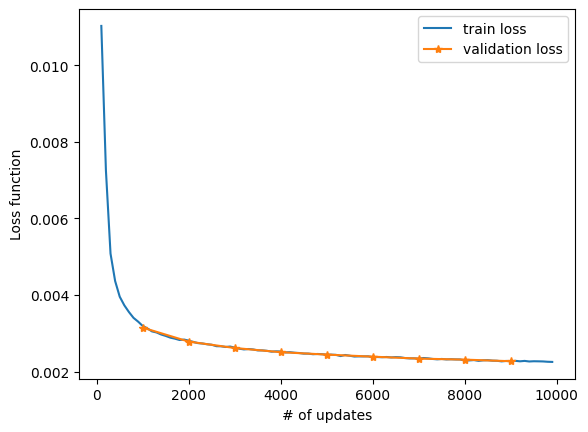

In [5]:
# P.148 リスト4.6: 4,5,6,7/smiles_lstm_main.py

import matplotlib.pyplot as plt
from smiles_vocab import SmilesVocabulary

# from smiles_lstm import SmilesLSTM, trainer
from rdkit import Chem


def valid_ratio(smiles_list: list[str]) -> float:
    """SMILES 文字列のリストから正しい SMILES 文字列の割合を計算

    Args:
        smiles_list (list[str]): SMILES 文字列のリスト

    Returns:
        float: 正しい SMILES 文字列の割合
    """
    n_success = 0
    for each_smiles in smiles_list:
        try:
            Chem.MolToSmiles(Chem.MolFromSmiles(each_smiles))
            n_success += 1
        except:
            pass
    return n_success / len(smiles_list)


if __name__ == "__main__":
    smiles_vocab = SmilesVocabulary()
    train_tensor: torch.Tensor = smiles_vocab.batch_update_from_file("train.smi")
    val_tensor: torch.Tensor = smiles_vocab.batch_update_from_file("val.smi")

    lstm = SmilesLSTM(smiles_vocab, hidden_size=512, n_layers=3)
    lstm, train_loss_list, val_loss_list = trainer(lstm, train_tensor, val_tensor)

    plt.plot(*list(zip(*train_loss_list)), label="train loss")
    plt.plot(*list(zip(*val_loss_list)), label="validation loss", marker="*")
    plt.legend()
    plt.xlabel("# of updates")
    plt.ylabel("Loss function")
    plt.savefig("smiles_lstm_learning_curve.pdf")
    # 1000 個の新規 SMILES 文字列を生成
    smiles_list: list[str] = lstm.generate(sample_size=1000)
    print("success rate: {}".format(valid_ratio(smiles_list)))

In [ ]:
import pickle

pickle.dump(smiles_vocab, open("4_smiles_vocab.pkl", "wb"))
pickle.dump(train_tensor, open("4_train_tensor.pkl", "wb"))
pickle.dump(val_tensor, open("4_val_tensor.pkl", "wb"))
pickle.dump(lstm, open("4_lstm.pkl", "wb"))
pickle.dump(train_loss_list, open("4_train_loss_list.pkl", "wb"))
pickle.dump(val_loss_list, open("4_val_loss_list.pkl", "wb"))
pickle.dump(smiles_list, open("4_smiles_list.pkl", "wb"))

# smiles_vocab: SmilesVocabulary = pickle.load(open("4_smiles_vocab.pkl", "rb"))
# train_tensor: torch.Tensor = pickle.load(open("4_train_tensor.pkl", "rb"))
# val_tensor: torch.Tensor = pickle.load(open("4_val_tensor.pkl", "rb"))
# lstm: SmilesLSTM = pickle.load(open("4_lstm.pkl", "rb"))
# train_loss_list = pickle.load(open("4_train_loss_list.pkl", "rb"))
# val_loss_list = pickle.load(open("4_val_loss_list.pkl", "rb"))
# smiles_list = pickle.load(open("4_smiles_list.pkl", "rb"))
